In [1]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import yfinance as yf

from datetime import timedelta, date, datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import set_random_seed
from keras.initializers import GlorotUniform


2023-12-08 23:12:17.808495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Reproducibility

set_random_seed(7)
tf.config.experimental.enable_op_determinism()

In [3]:
# Retrieve stock data from Yahoo Finance

# stock_list = ['AAPL', 'TSLA', 'XOM', 'JPM']
stock_list = ['AAPL']

# Date range is 50 days + 1 year + 1 month.
# 50 day start buffer is for 50-day EMA calculations.
# 1 month end buffer is for price prediction.
# Model will only be run on the 1 year data.
end_date_buffer = date(2023, 11, 26)
end_date = end_date_buffer - timedelta(days=31)
start_date = date(2013, 11, 26)
start_date_buffer = start_date - timedelta(days=50)

# Date to string
start = start_date.strftime('%Y-%m-%d')
end = end_date.strftime('%Y-%m-%d')

stock_dfs = []
for stock in stock_list:
    df = yf.Ticker(stock).history(start=start_date_buffer, end=end_date_buffer)
    # Only need closing price data
    stock_dfs.append(pd.DataFrame(df['Close']).rename(columns={'Close':'Price'})) 

    
for stock_df in stock_dfs:
    stock_df.index = stock_df.index.strftime('%Y-%m-%d')
    
    # Check for missing values
    print(stock_df.isnull().values.any()) 

False


In [4]:
# Calculate momentum, volatility and EMAs (7, 20, and 50-day)

ma_day = [7, 20, 50]

for stock_df in stock_dfs:
    stock_df['Momentum'] = np.where(stock_df['Price'] < stock_df['Price'].shift(1), 0, 1)
    stock_df['Volatility'] = (stock_df['Price'].shift(1)-stock_df['Price'])/stock_df['Price'].shift(1)
    for ma in ma_day:
        ema_column = '%sEMA' % ma
        stock_df[ema_column] = ( 
            stock_df['Price'].ewm(span=ma, adjust=False).mean()
        )
    
    # Calculations complete, the start buffer can be removed
    stock_df.drop(stock_df.loc[:start].index, inplace=True)
    print(stock_df.head(1))

                Price  Momentum  Volatility       7EMA      20EMA      50EMA
Date                                                                        
2013-11-27  17.094233         1   -0.023547  16.578625  16.355709  16.009971


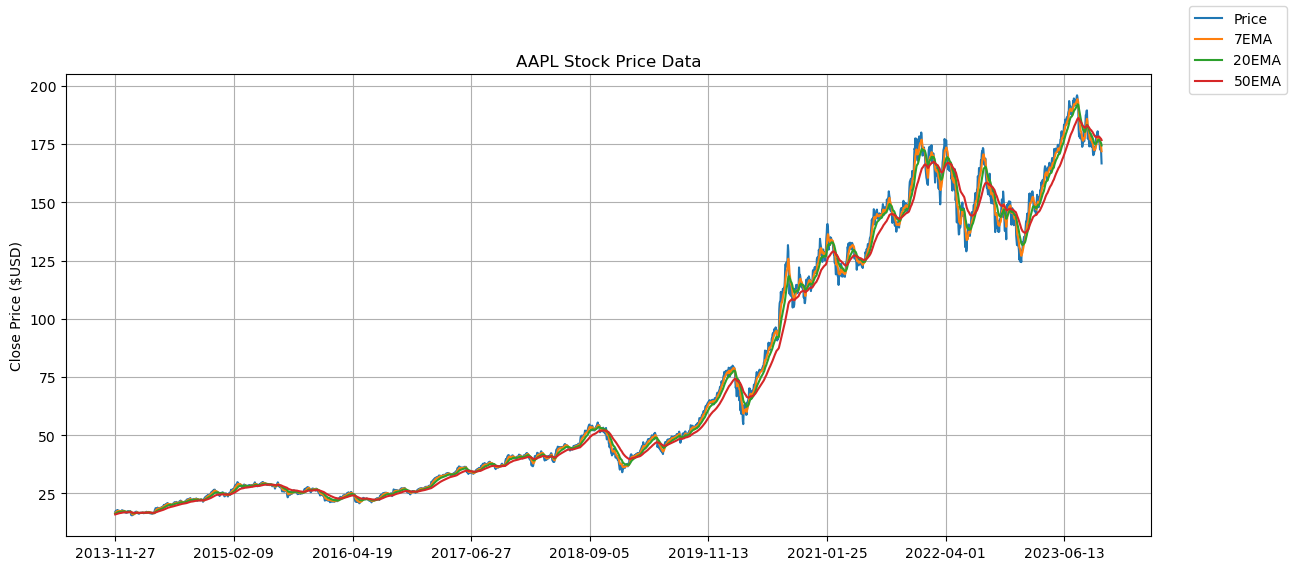

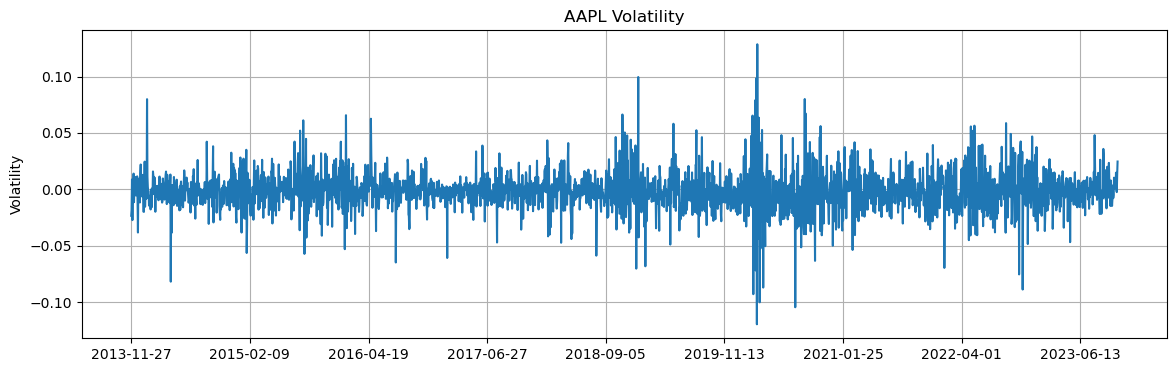

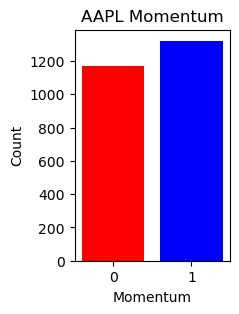

In [5]:
# Plot a year of data from all stock dataframes

for i, stock in enumerate(stock_list):
    plot_df = stock_dfs[i].loc[:end]
    
    fig, ax = plt.subplots(figsize=(14,6))
    for col in plot_df.columns.values:
        if col == 'Price' or col.endswith('EMA'):
            ax.plot(plot_df[col], label=col)
    
    ax.set(title='%s Stock Price Data' % stock, ylabel='Close Price ($USD)')
    ax.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax.grid(visible=True, which='both')
    fig.legend()
    
    fig, ax = plt.subplots(figsize=(14,4))
    ax.plot(plot_df["Volatility"])
    ax.set(title='%s Volatility' % stock, ylabel='Volatility')
    ax.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax.grid(visible=True, which='both')
    
    fig, ax = plt.subplots(figsize=(2,3))
    momentum_counts = plot_df['Momentum'].value_counts().reindex([0,1])
    ax.bar(['0','1'], momentum_counts, color=['r', 'b'])
    ax.set(title='%s Momentum' % stock, xlabel='Momentum', ylabel='Count')

    plt.show()


In [6]:
# Create data for actual future prices.

# There is a roadblock here;
# the stock market is closed on weekends and holidays,
# meaning that some future prices will simply not exist.
# E.g. the day a week from 11/19/23 is Thanksgiving,
# so there is no trading data for that day.
# We must loop through manually and set the value to NaN in these cases.
# Rows with NaN can then be removed when creating training sets.

for stock_df in stock_dfs:

    predictions = {'WeekActual':7, '2WeeksActual':14, '4WeeksActual':28}

    # Instantiate prediction columns
    for pred_name in predictions:
        stock_df[pred_name] = 0

    # Loop through dates
    for index in stock_df.index:
        index_date = datetime.strptime(index, '%Y-%m-%d')

        for pred_name, pred_days in predictions.items():
            future_date = (index_date + timedelta(days=pred_days)).strftime('%Y-%m-%d')

            if future_date in stock_df.index:
                stock_df[pred_name][index] = stock_df.loc[future_date]['Price']
            else:
                stock_df[pred_name][index] = None

    print(stock_df.head(1))

/tmp/ipykernel_34302/1455373105.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df[pred_name][index] = stock_df.loc[future_date]['Price']
/tmp/ipykernel_34302/1455373105.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df[pred_name][index] = stock_df.loc[future_date]['Price']
/tmp/ipykernel_34302/1455373105.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df[pred_name][index] = None


                Price  Momentum  Volatility       7EMA      20EMA      50EMA  \
Date                                                                           
2013-11-27  17.094233         1   -0.023547  16.578625  16.355709  16.009971   

            WeekActual  2WeeksActual  4WeeksActual  
Date                                                
2013-11-27   17.690378     17.576414           NaN  


In [7]:
# Linear Regression

test_size = 0.25

regression_dfs = []

for i, stock in enumerate(stock_list):
    stock_df = stock_dfs[i]
    
    X_prep = stock_df.loc[:end]
    
    # Prepare training data. Remove all week predictions from X dataset
    for pred_name in predictions:
        X_prep = X_prep.drop(columns=[pred_name])
    
    # Regression for each prediction length
    for pred_name in predictions:
        
        # Add back the week prediction being used to remove null values
        X_prep[pred_name] = stock_df[pred_name]
        X = X_prep.dropna()
        y = X[pred_name]
        
        # Then drop the prediction column before training
        X = X.drop(columns=[pred_name])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        lr = LinearRegression()
        lr.fit(X_train, y_train)

        print('\n~~~%s %s Prediction~~~' % (stock, pred_name.replace("Actual", "")))
        print("R^2: ", lr.score(X_test, y_test))
    
        pred_col = pred_name.replace("Actual", "Predicted")
        X_test[pred_col] = lr.predict(X_test)
        X_test[pred_name] = y_test
        print("MSE: ", mean_squared_error(X_test[pred_name], X_test[pred_col]))
        
        X_test = X_test.sort_index()
        regression_dfs.append(X_test)
        X_prep = X_prep.drop(columns=[pred_name])



~~~AAPL Week Prediction~~~
R^2:  0.9954789946890183
MSE:  14.248264346730307

~~~AAPL 2Weeks Prediction~~~
R^2:  0.9927851326984486
MSE:  21.437829352536255

~~~AAPL 4Weeks Prediction~~~
R^2:  0.9827701339488099
MSE:  51.62280135755929


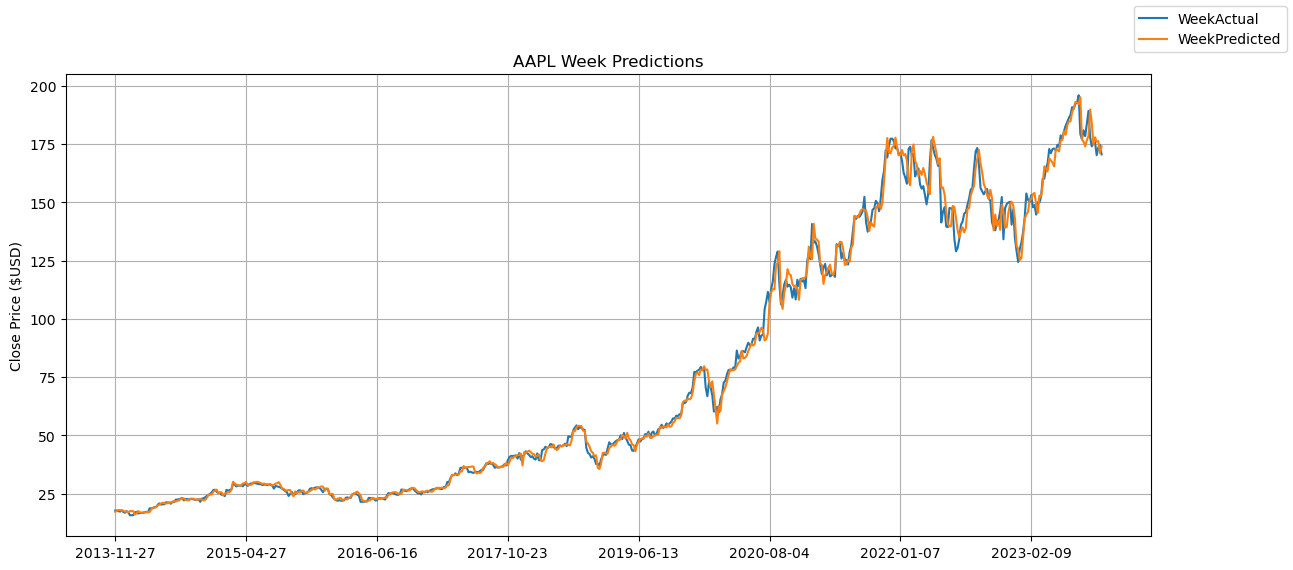

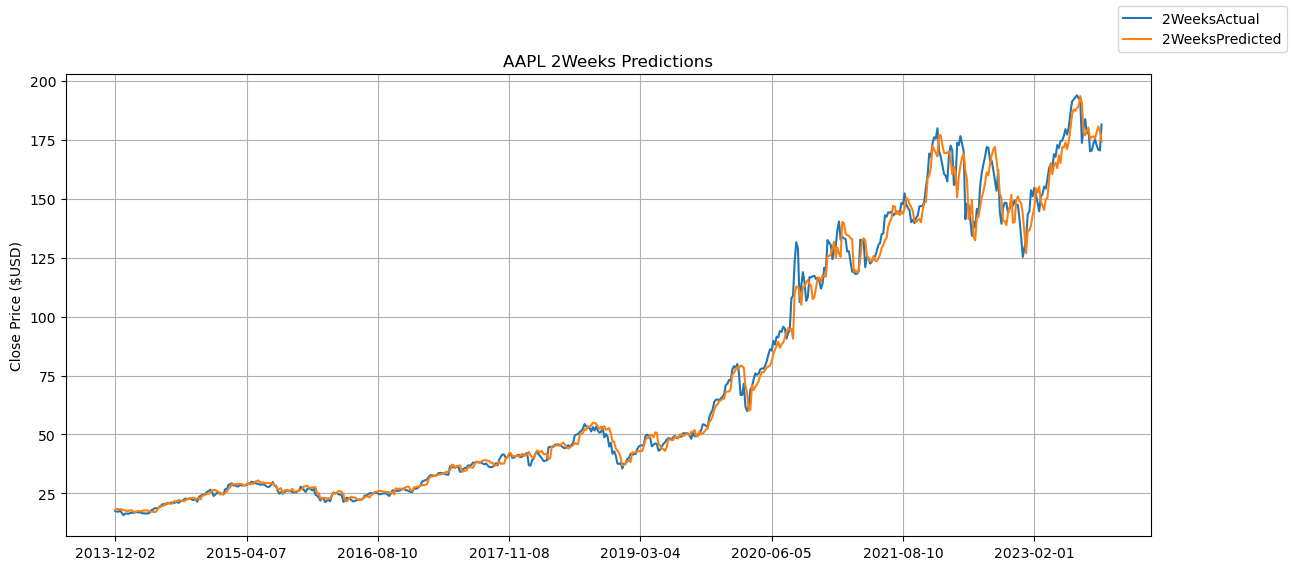

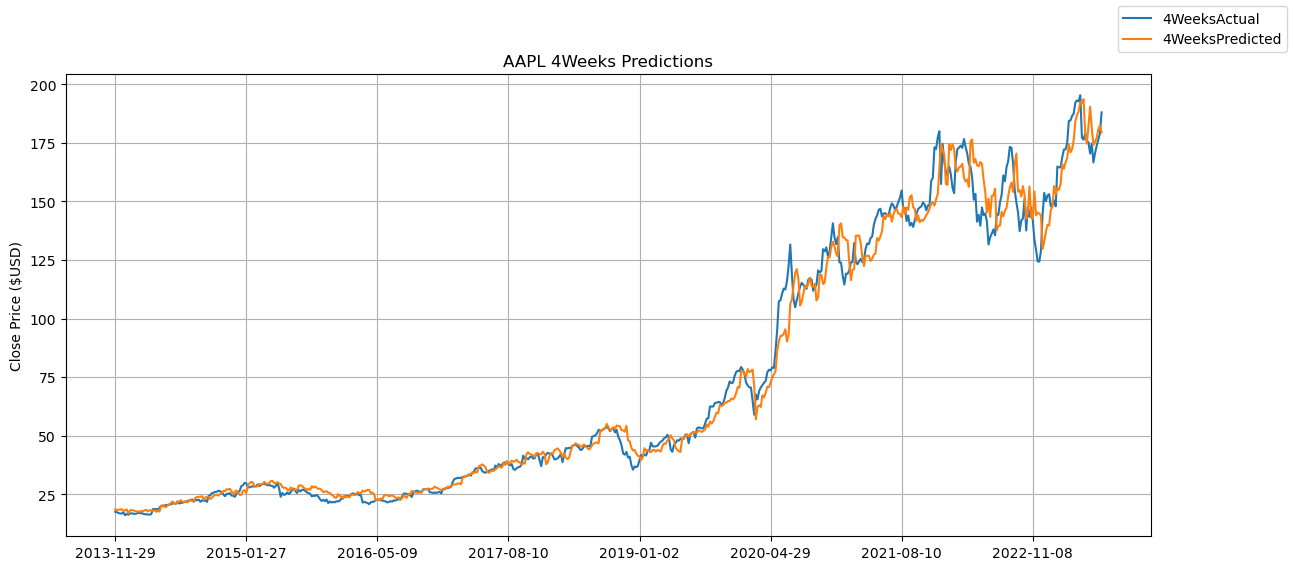

In [8]:
# Plot the predictions

ctr = 0
for i, stock in enumerate(stock_list):
    for pred_name in predictions:
        
        regression_df = regression_dfs[ctr]

        fig, ax = plt.subplots(figsize=(14,6))
        ax.plot(regression_df[pred_name], label=pred_name)

        pred_col = pred_name.replace("Actual", "Predicted")
        plt.plot(regression_df[pred_col], label=pred_col)

        ax.set(ylabel='Close Price ($USD)')
        ax.set_title('%s %s Predictions' % (stock, pred_name.replace("Actual", "")))
        
        ax.xaxis.set_major_locator(mticker.MaxNLocator(10))
        ax.grid(visible=True, which='both')
        
        fig.legend()
        plt.show()
        
        ctr += 1

In [9]:
# Train Long-Short Term Memory (LSTM) Model

test_size = 0.25

lstm_dfs = []

for i, stock_df in enumerate(stock_dfs):
    stock = stock_list[i]
    
    X_prep = stock_df.loc[:end]
    
    # Prepare training data. Remove all week predictions from X dataset
    for pred_name in predictions:
        X_prep = X_prep.drop(columns=[pred_name])
    
    # Regression for each prediction length
    for pred_name in predictions:
        
        # Add back the week prediction being used to remove null values
        X_prep[pred_name] = stock_df[pred_name]
        X = X_prep.dropna()
        y = X[pred_name]
        
        # Then drop the prediction column before training
        X = X.drop(columns=[pred_name])
        
        # Split into training and testing data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
        
        # Normalize training data between 0 and 1
        X_train_np, y_train_np = np.array(X_train), np.array(y_train)
        
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        
        X_train_scaled = X_scaler.fit_transform(X_train_np)
        y_train_scaled = y_scaler.fit_transform(y_train_np.reshape(-1, 1))
        
        # Create and fit the model
        # kernel_initializer is used for reproducibility.
        model = Sequential()
        model.add(LSTM(1024, return_sequences=True, input_shape= (X_train_scaled.shape[1], 1), kernel_initializer=GlorotUniform(seed=7)))
        model.add(Dropout(0.2, seed=7))
        model.add(LSTM(64, return_sequences=False, kernel_initializer=GlorotUniform(seed=7)))
        model.add(Dropout(0.2, seed=7))
        model.add(Dense(32, kernel_initializer=GlorotUniform(seed=7)))
        model.add(Dense(1, kernel_initializer=GlorotUniform(seed=7)))
        
        model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mse'])
        model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=1)
        
        # Normalize testing data
        X_test_np, y_test_np = np.array(X_test), np.array(y_test)
        
        X_test_scaled = X_scaler.transform(X_test_np)
        y_test_scaled = y_scaler.transform(y_test_np.reshape(-1, 1))
        
        predicted_scaled_price = model.predict(X_test_scaled)
        predicted_price = y_scaler.inverse_transform(predicted_scaled_price).reshape(-1)
        
        pred_col = pred_name.replace("Actual", "Predicted")
        lstm_df = pd.DataFrame(predicted_price, columns=[pred_col], index=y_test.index).sort_index()
        lstm_df[pred_name] = y_test
        lstm_dfs.append(lstm_df)
        
        print('\n~~~%s %s Prediction~~~' % (stock, pred_name.replace("Actual", "")))
        
        print("R^2: ", r2_score(lstm_df[pred_name], lstm_df[pred_col]))
        print("MSE: ", mean_squared_error(lstm_df[pred_name], lstm_df[pred_col]))
        
        X_prep = X_prep.drop(columns=[pred_name])


19/19 [==============================] - 1s 31ms/step

~~~AAPL Week Prediction~~~
R^2:  0.989247237145318
MSE:  33.88808397085147
19/19 [==============================] - 1s 30ms/step

~~~AAPL 2Weeks Prediction~~~
R^2:  0.9832546149578435
MSE:  52.263753898503815
19/19 [==============================] - 1s 32ms/step

~~~AAPL 4Weeks Prediction~~~
R^2:  0.9680675954451995
MSE:  101.48983445578598


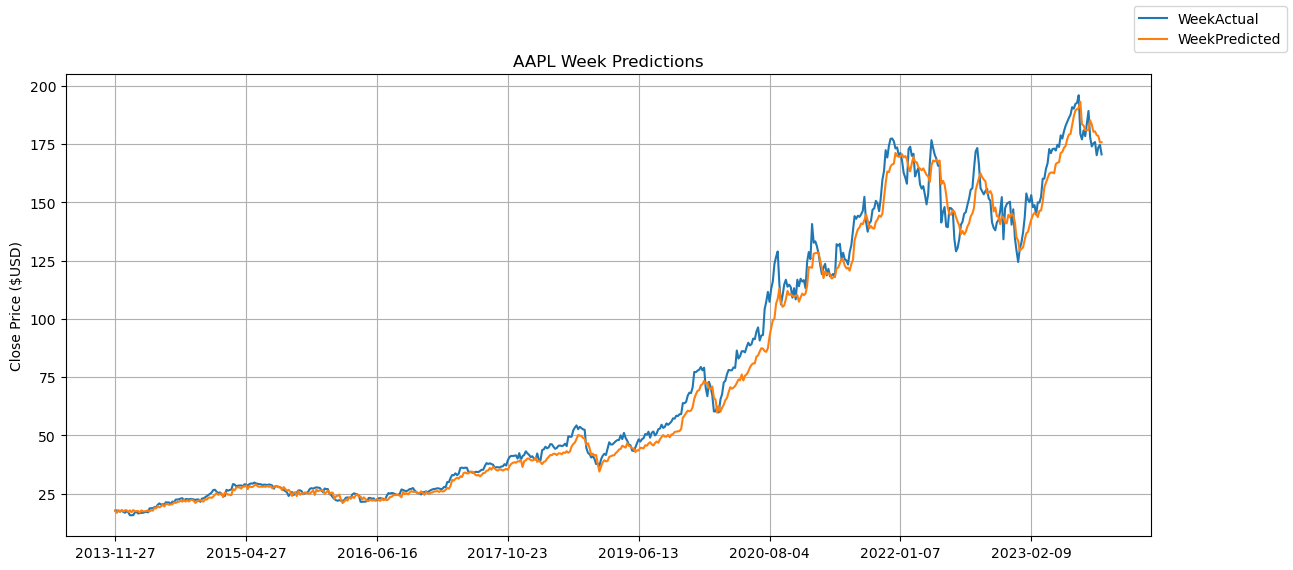

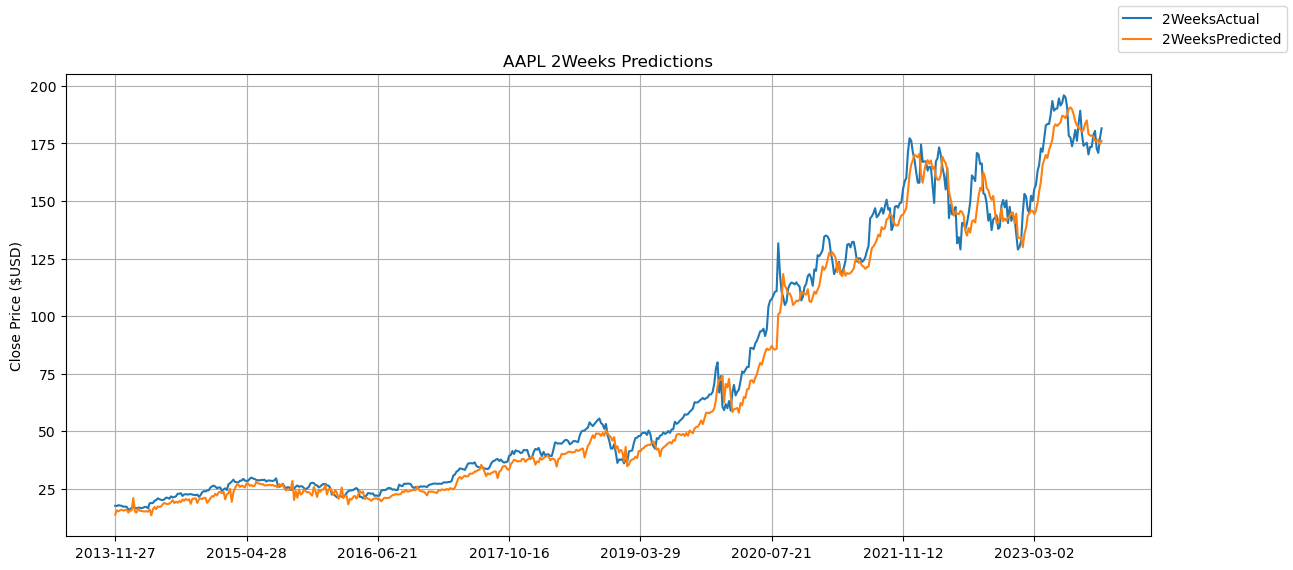

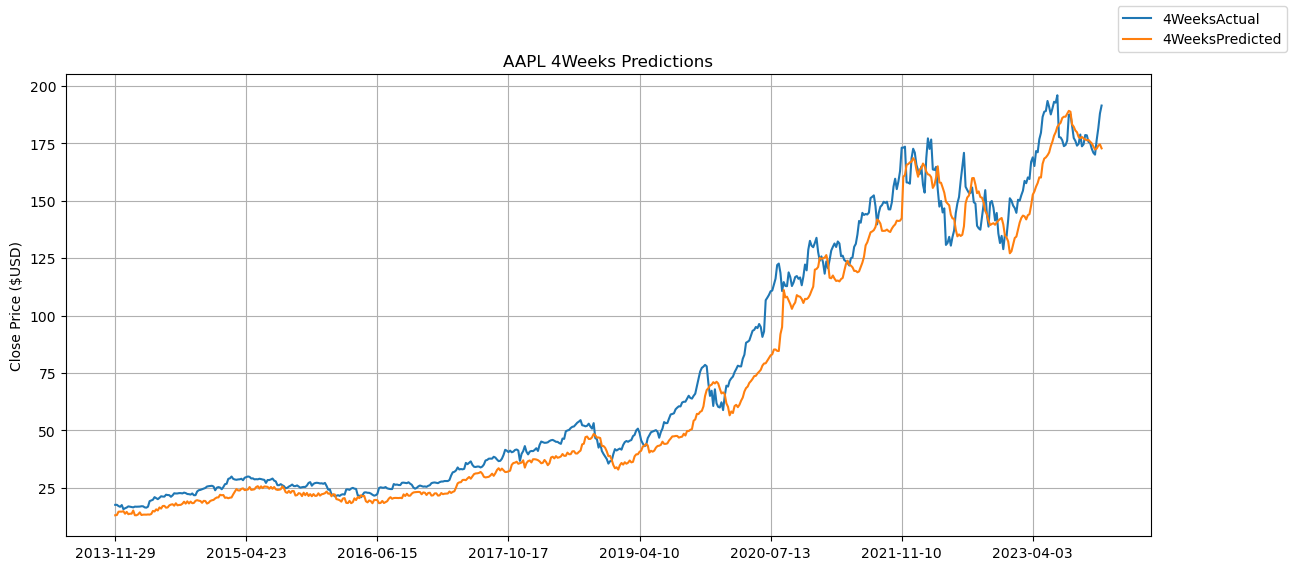

In [10]:
# Plot the predictions

ctr = 0
for i, stock in enumerate(stock_list):
    for pred_name in predictions:
        
        lstm_df = lstm_dfs[ctr]

        fig, ax = plt.subplots(figsize=(14,6))
        ax.plot(lstm_df[pred_name], label=pred_name)

        pred_col = pred_name.replace("Actual", "Predicted")
        plt.plot(lstm_df[pred_col], label=pred_col)

        ax.set(ylabel='Close Price ($USD)')
        ax.set_title('%s %s Predictions' % (stock, pred_name.replace("Actual", "")))
        
        ax.xaxis.set_major_locator(mticker.MaxNLocator(10))
        ax.grid(visible=True, which='both')
        
        fig.legend()

        plt.show()
        
        ctr += 1